### Import libraries

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from utility import *
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from collections import deque

In [2]:
# Divide up into cars and notcars
cars = glob.glob('vehicles/*.png')
notcars = glob.glob('non-vehicles/*.png')

sample_size = 2000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
1.92 Seconds to train SVC...
Test Accuracy of SVC =  0.9825


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


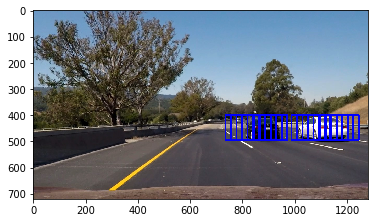

In [3]:
image = mpimg.imread('test_images/test6.jpg')
image = image.astype(np.float32)/255
draw_image = np.copy(image)

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                    xy_window=(110, 96), xy_overlap=(0.8, 0.8))
windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[500, 600], 
                    xy_window=(128, 108), xy_overlap=(0.8, 0.8)))
windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[600, 650], 
                    xy_window=(136, 116), xy_overlap=(0.8, 0.8)))
windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[650, 700], 
                    xy_window=(144, 124), xy_overlap=(0.8, 0.8)))
windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[700, None], 
                    xy_window=(160, 140), xy_overlap=(0.8, 0.8)))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.imshow(window_img)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


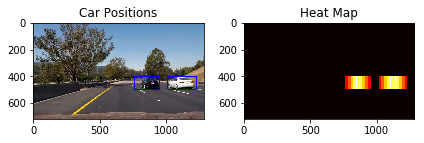

In [4]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [5]:
def process_image(image):
    image = image.astype(np.float32)/255
    draw_image = np.copy(image)

    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[400, 500], 
                        xy_window=(110, 96), xy_overlap=(0.8, 0.8))
    windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[500, 600], 
                        xy_window=(128, 108), xy_overlap=(0.8, 0.8)))
    windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[600, 650], 
                        xy_window=(144, 116), xy_overlap=(0.8, 0.8)))
    windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[650, 700], 
                        xy_window=(156, 124), xy_overlap=(0.8, 0.8)))
    windows.extend(slide_window(image, x_start_stop=[None, None], y_start_stop=[700, None], 
                        xy_window=(180, 156), xy_overlap=(0.8, 0.8)))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)

    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
#     d.append(heatmap)
#     if (len(d) > 5):
#         d.popleft() 
#     avg_heatmap = (np.ceil(np.average(d)*5)).astype(int)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    draw_img = (draw_img*255).astype(np.uint8)
    return draw_img

In [6]:
from moviepy.editor import VideoFileClip

In [7]:
white_output = 'output_images/test_output.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(14,16)
clip1 = VideoFileClip("project_video.mp4")
d = deque() 
white_clip = clip1.fl_image(process_image)
# white_clip = clip1.fl_image(lambda image: process_image(image, d))
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/test_output.mp4
[MoviePy] Writing video output_images/test_output.mp4


100%|█████████▉| 1260/1261 [10:05<00:00,  2.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_output.mp4 

CPU times: user 38min, sys: 1min 29s, total: 39min 30s
Wall time: 10min 6s
